 # Computational Quantitative Finance Term 2 Summative

# Investment stratergy

The investment strategy implemented here is based on long term price reversal. This pricing anomaly was first suggested by Thaler (1985) and observes that for the bottom 35 stocks, ranked by cumulative abnormal return (CAR), over the course of 3 years there is an increase in CAR for this loser portfolio Similarly, the winner portfolio experiences a declining CAR across the same three year holding period.

![thaler%20diagra,.png](attachment:thaler%20diagra,.png)

This suggests a possible long term investment strategy to which a the start of the three year holding period, the stocks predicted to be losers should be subject to a long position to capitalize on the expected increase in CAR over the holding period. In contrast, stocks identified to be winners should be shorted over the 3 years to benefit from the expected decline in returns.


There is therefore a potential relationship between a stocks ranking, determined by its previous 3 year CAR (Thaler, 1985)  and the returns it experiences over the next 3 years. Bearing this in mind, it is possible to teach a machine learning model this long term price reversal relationship. It is important to note this forms a long term investment strategy, and one which is different to a momentum-based strategy:  typically a long position is entered on the winner portfolio for approximately 12 months, as opposed to the short position for 36 months found here.

The terms observation and holding period are used frequently throughout this report. The observation period refers to the length to which the return metric, and therefore subsequent ranking, is calculated whereas the holding period refers to the period to which the winner and losers are held, and is used in the training set to provide the target label. The choice on the length of the observation and holding period are derived from Thaler (1985) ; this results in a length for both periods of 36 months.  


## Artifical Neural Network


An Artificial Neural Network (ANN) was chosen to model this relationship due to its ability to capture non-linear, complex relationships between the features and the target through supervised learning.

Specifically, the nature of the investment strategy means the input and output layers remain fixed and there is no recurrence (internal memory used in the ANN. With the inclusion of many layers, this model is therefore described as a multilayer perceptron (MLP) NN and is well suited for the timer series prediction setting (Li and Tam, 2018).

The MLP will take the form of a classifier as opposed to a regression model. The assigned class label is derived from a ranking of cumulative returns and is associated with the class given for the ranking of the same stock at the end of the period.

The nature of this problem means the specific MLP classification model implemented is regarded as a multiclass problem since the classes given to the ranked stocks are mutually exclusive, in contrast to a multilabel problem.


## MLP classifier system:



The (ANN) consists of layers, starting with the input layer, then the hidden layer, and then the output layer. In each layer, there are a number of units. And the hidden layer can consist of many layers but the label remains the same.

Each perceptron unit takes x, which is the output from the previous layer, multiplies it by the weight of that neuron and then adds the bias for that layer. This value is then transformed according to the chosen activation function, and then this output becomes the input for the unit in the next layer. This is shown below in Equation 1 and the Weight and bias terms are labelled as ‘parameters’.


yj (t) = f [ W (t) dot prod xj ]

The purpose of the activation function is to introduce non-linearity into the NN, allowing it to capture a non-linear relationship between the input features and the target. There are a range of possible activation functions to which the choice becomes a ‘hyperparameter’ decision; this is covered in the hyperparameter tuning section.

After the forward propagation wave reaches the output layer, the output is then compared against the true value of y provided in the training set. The difference is calculated according to the cost function. An optimiser, sometimes called a solver, views the cost function as a function of the weights and biases and optimizes these parameters as a minimisation problem.

The weights and biases of the network are updated through a process called backpropagation: taking the partial derivative of the cost function with respect to the individual parameters which are then modified according to the chain rule.

This process of forward and backward propagation occurs for each sample in the training set. The resultant neural network takes the test set, a set that has not been seen by the NN, and a loss function is calculated to which hyperparameters can be tuned against


# Implementation

## Data set preprocessing:


First, the price column of the data set is modified to only include absolute prices, this is because the data obtained from CRSP may contain negative price values if there was no closing price available for the period. Secondly, the top and bottom 3% of the price and return data is classed as outliers and is therefore removed.


## Label generation

The column titled 'prev_3yr_prc' is used instrumentally in order to calculate the 36-month cumulative return column titled '3yr_cumret' according to equation 2 below. This resultant value is used to provide both the label for the observation period and the target label for the holding period.

Cumulative return = (price_t - price_t-36 )/ price_t-36

At the end of the observation period month, the companies are assigned a label dependent on their ranking relative to other stocks returns for the observation period. After the 3 years holding period has finished,  the 3-year cumulative return for this period is used as an ex-post value they are ranked against and assigned a label.

Shifting this label back by 36 months to the end of the holding period delivers a sample set that includes a label from the holding period and a target label for the subsequent holding period.

With such a large amount of monthly data needed to construct these labels, and also the shifting required to provide the target label, there will be many rows containing Nan Values; these are removed to create a continuous data set.


## Feature extraction:

Whilst deep learning internalizes the feature extraction process, it is alternatively done here through intuition and knowledge of financial price activity. As such, the input features of cumulative return and momentum factors are chosen as we estimate that they will contain some informational content regarding the long term reversal process. Additionally, different forms of these features with varying lengths are also included to capture price action patterns across multiple time spans.

Similar to the previous year's price columns, the ‘prd’ column of the feature extraction stage is only used instrumentally and is later removed.


### Feature Analysis

# Model Training

With the training set constructed,  a tentative MLP classifier model is defined using initial hyperparameters. The activation function of Sigmoid is chosen for the tentative model because, whilst relu is the most popular activation function, the sigmoid activation function (logistic function) is suggested as the most suited for classification Neural networks ( Sharma, 2020). Adam is chosen over Stochastic gradient descent to be included as it is suited to the large data set and displays fast convergence speeds

In-sample score (Training Set score) : 0.1644112943957649
Out of sample score (Test Set score ) :0.14916112371195325


In [ ]:
# Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Loading Data
crsp = pd.read_csv('crsp2.csv')
crsp['date'] = pd.to_datetime(crsp.date) # String to Timestamp
crsp['prc'] = crsp.prc.abs()

# Removing Outliers (Top and Bottom 3%)
lb = crsp.quantile(q = 0.03)
ub = crsp.quantile(q = 0.97)
crsp = crsp[crsp.ret >= lb.ret]
crsp = crsp[crsp.ret <= ub.ret]
crsp = crsp[crsp.prc >= lb.prc]
crsp = crsp[crsp.prc <= ub.prc]

# Creating Labels
crsp['prev_3yr_prc'] = crsp.groupby('permno')['prc'].shift(36)
crsp['3yr_cumret'] = (crsp['prc'] - crsp['prev_3yr_prc']) / crsp['prev_3yr_prc']
crsp.sort_values(['permno','date'], inplace=True)
crsp['label'] = crsp.groupby('date')['3yr_cumret'].apply(lambda x: pd.qcut(-x, 10, labels=False, duplicates = 'drop')) # make the label
crsp['tgt_3yr_cumret'] = crsp.groupby('permno')['3yr_cumret'].shift(-36) # Shift the return three years back to t
crsp['tgt_label'] = crsp.groupby('permno')['label'].shift(-36) # Shift the label three years back to t

# Dropping Rows with Missing Values
crsp.dropna(inplace=True)
crsp

,date,permno,prc,vol,ret,shrout,prev_3yr_prc,3yr_cumret,label,tgt_3yr_cumret,tgt_label
57,1989-02-28,10001,6.75,417.0,0.038462,998.0,6.2500,0.080000,3.0,0.629630,2.0
58,1989-03-31,10001,6.75,241.0,0.017778,998.0,6.3125,0.069307,2.0,0.740741,1.0
59,1989-04-28,10001,7.25,310.0,0.074074,998.0,6.3750,0.137255,2.0,0.637931,1.0
60,1989-05-31,10001,7.00,629.0,-0.034483,998.0,6.3125,0.108911,2.0,0.714286,1.0
61,1989-06-30,10001,7.00,200.0,0.017143,1001.0,6.1250,0.142857,2.0,0.678571,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4222747,2018-03-29,93434,3.60,8686.0,0.028571,24338.0,4.6200,-0.220779,7.0,0.011111,6.0
4222748,2018-04-30,93434,3.55,4505.0,-0.013889,24338.0,4.5300,-0.216336,7.0,-0.061972,6.0
4222749,2018-05-31,93434,3.45,10649.0,-0.028169,24343.0,4.4850,-0.230769,7.0,-0.191304,7.0
4222750,2018-06-29,93434,3.25,9060.0,-0.057971,25991.0,4.8800,-0.334016,8.0,-0.203077,7.0


In [ ]:
# Feature Creation
# List of features: 1-, 3- and 5-year cumulative returns and 1-, 3-, and 5-year momentums

# Cumulative Returns:

# Step 1 - Add Construction Columns

crsp['prev_1yr_prc'] = crsp.groupby('permno')['prc'].shift(12)
crsp['prev_5yr_prc'] = crsp.groupby('permno')['prc'].shift(60)

# Step 2 - Add Features Calculated Using Construction Columns

crsp['1yr_cumret'] = (crsp['prc'] - crsp['prev_1yr_prc']) / crsp['prev_1yr_prc']
crsp['5yr_cumret'] = (crsp['prc'] - crsp['prev_5yr_prc']) / crsp['prev_5yr_prc']

# Momentum:

crsp['cumret'] = crsp.groupby('permno')['ret'].apply(lambda x: (1+x).cumprod())
gb = crsp.groupby('permno')
numer = gb.shift(1)

# 6-month momentum
denom = gb.shift(6)
crsp['mom6m'] = numer.cumret/denom.cumret - 1
crsp['prd6m'] = 12*(numer.date.dt.year - denom.date.dt.year) \
                    + (numer.date.dt.month - denom.date.dt.month) + 1 # number of actual months

# 1year momentum
denom = gb.shift(12)
crsp['mom1y'] = numer.cumret/denom.cumret - 1
crsp['prd1y'] = 12*(numer.date.dt.year - denom.date.dt.year) \
                    + (numer.date.dt.month - denom.date.dt.month) + 1 # number of actual months

# 3 year momentum
denom = gb.shift(36)
crsp['mom3y'] = numer.cumret/denom.cumret - 1
crsp['prd3y'] = 12*(numer.date.dt.year - denom.date.dt.year) \
                    + (numer.date.dt.month - denom.date.dt.month) + 1 # number of actual months

# 5 year momentum
denom = gb.shift(60)
crsp['mom5y'] = numer.cumret/denom.cumret - 1
crsp['prd5y'] = 12*(numer.date.dt.year - denom.date.dt.year) \
                    + (numer.date.dt.month - denom.date.dt.month) + 1 # number of actual months

crsp.drop(columns=['prd1y','prd6m','prd5y','prev_1yr_prc','prev_5yr_prc'], inplace=True)
crsp.drop(columns=['prev_3yr_prc','cumret','prd3y'], inplace=True)

crsp.dropna(inplace=True)
crsp



,date,permno,prc,vol,ret,shrout,3yr_cumret,label,tgt_3yr_cumret,tgt_label,1yr_cumret,5yr_cumret,mom6m,mom1y,mom3y,mom5y
117,1994-02-28,10001,17.500000,58.0,0.000000,1091.0,0.794872,3.0,-0.507143,8.0,0.228070,1.592593,0.124488,0.279998,1.066355,2.351284
118,1994-03-31,10001,17.250000,133.0,-0.004286,1091.0,0.815789,2.0,-0.500000,8.0,0.210526,1.555556,0.054726,0.266005,1.090476,2.292746
119,1994-04-29,10001,14.750000,102.0,-0.144928,1091.0,0.493671,3.0,-0.415254,8.0,-0.032787,1.034483,0.019765,0.177919,1.002472,2.052521
120,1994-05-31,10001,15.750000,146.0,0.067797,1091.0,0.594937,2.0,-0.452381,8.0,0.041322,1.250000,-0.115204,0.015530,0.712259,1.703346
121,1994-06-30,10001,8.625000,234.0,0.107302,2191.0,-0.178571,7.0,-0.043478,6.0,-0.477273,0.232143,-0.134161,-0.016418,0.695296,1.837973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4222076,2018-08-31,93426,43.299999,19222.0,0.085213,12449.0,2.869526,0.0,-0.136952,7.0,0.981693,2.064402,0.332220,0.826087,2.565684,1.823779
4222077,2018-09-28,93426,37.400002,13258.0,-0.136259,12449.0,2.226920,0.0,-0.070321,6.0,0.532787,1.570447,0.390048,0.774590,2.735979,1.975945
4222078,2018-10-31,93426,32.450001,15019.0,-0.132353,12449.0,1.766411,0.0,0.050539,5.0,0.321792,0.978659,0.321555,0.523422,2.188406,1.280488
4222079,2018-11-30,93426,33.930000,15352.0,0.045609,12449.0,1.820449,0.0,0.011789,6.0,0.224910,0.995882,-0.135819,0.171480,1.697423,0.908824


In [ ]:
# remove rows with missing months
#crsp.drop(columns=['prd1y','prd6m','prd5y','prev_1yr_prc','prev_5yr_prc'], inplace=True)
#crsp.drop(columns=['prev_3yr_prc','cumret','prd3y'], inplace=True)
#crsp
#save csv

#crsp.to_csv('crsp13_filtered.csv', index=False)

,1yr_cumret,3yr_cumret,5yr_cumret,mom6m,mom1y,mom3y,mom5y
1yr_cumret,1.000000,0.383415,0.242063,0.277997,0.395291,0.088733,0.025597
3yr_cumret,0.383415,1.000000,0.531201,0.182988,0.254657,0.365462,0.127028
5yr_cumret,0.242063,0.531201,1.000000,0.149521,0.215804,0.304256,0.316667
mom6m,0.277997,0.182988,0.149521,1.000000,0.665130,0.348502,0.247943
mom1y,0.395291,0.254657,0.215804,0.665130,1.000000,0.523776,0.376291
mom3y,0.088733,0.365462,0.304256,0.348502,0.523776,1.000000,0.715622
mom5y,0.025597,0.127028,0.316667,0.247943,0.376291,0.715622,1.000000


tgt_3yr_cumret    1.000000
label             0.144650
vol               0.026697
permno            0.013871
shrout            0.005641
ret              -0.047056
1yr_cumret       -0.069384
3yr_cumret       -0.094593
mom6m            -0.100388
5yr_cumret       -0.100894
mom1y            -0.131516
mom5y            -0.151822
mom3y            -0.159234
prc              -0.225729
tgt_label        -0.555100
Name: tgt_3yr_cumret, dtype: float64

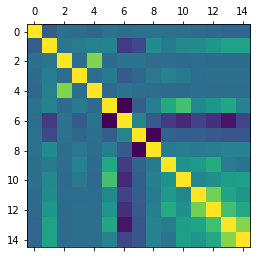

In [ ]:
# Check Pairwise Correlations

crsp[['1yr_cumret','3yr_cumret', '5yr_cumret','mom6m', 'mom1y', 'mom3y','mom5y'] ].corr()
crsp.corr().tgt_3yr_cumret.sort_values(ascending=False) # correlations between the target and the features.

plt.matshow(crsp.corr())

<AxesSubplot:xlabel='1yr_cumret', ylabel='Density'>

<AxesSubplot:xlabel='1yr_cumret', ylabel='Density'>

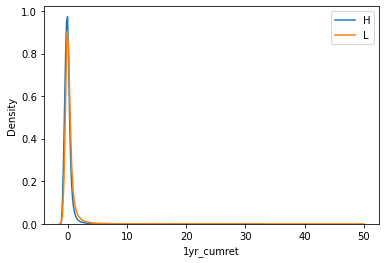

<AxesSubplot:xlabel='3yr_cumret', ylabel='Density'>

<AxesSubplot:xlabel='3yr_cumret', ylabel='Density'>

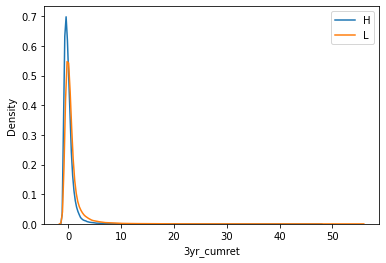

<AxesSubplot:xlabel='5yr_cumret', ylabel='Density'>

<AxesSubplot:xlabel='5yr_cumret', ylabel='Density'>

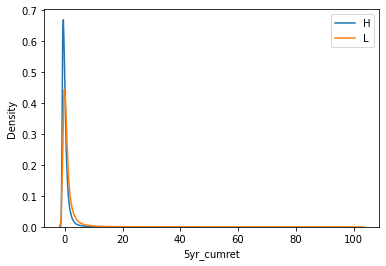

<AxesSubplot:xlabel='mom6m', ylabel='Density'>

<AxesSubplot:xlabel='mom6m', ylabel='Density'>

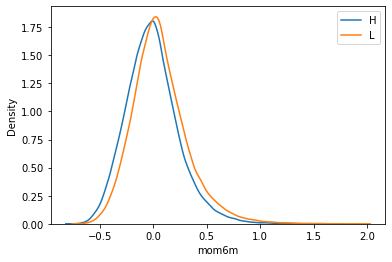

<AxesSubplot:xlabel='mom1y', ylabel='Density'>

<AxesSubplot:xlabel='mom1y', ylabel='Density'>

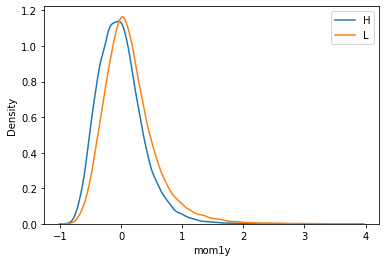

<AxesSubplot:xlabel='mom3y', ylabel='Density'>

<AxesSubplot:xlabel='mom3y', ylabel='Density'>

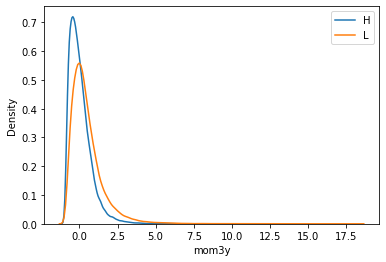

<AxesSubplot:xlabel='mom5y', ylabel='Density'>

<AxesSubplot:xlabel='mom5y', ylabel='Density'>

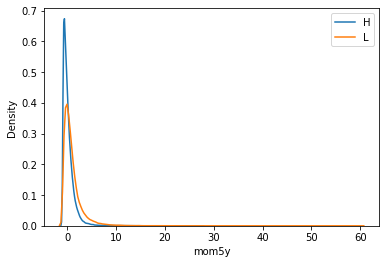

In [ ]:
sns.kdeplot(crsp[crsp['tgt_label'] == 0]['1yr_cumret'], label='H')
sns.kdeplot(crsp[crsp['tgt_label'] == 9]['1yr_cumret'], label='L')
plt.legend()
plt.show()

sns.kdeplot(crsp[crsp['tgt_label'] == 0]['3yr_cumret'], label='H')
sns.kdeplot(crsp[crsp['tgt_label'] == 9]['3yr_cumret'], label='L')
plt.legend()
plt.show()

sns.kdeplot(crsp[crsp['tgt_label'] == 0]['5yr_cumret'], label='H')
sns.kdeplot(crsp[crsp['tgt_label'] == 9]['5yr_cumret'], label='L')
plt.legend()
plt.show()

sns.kdeplot(crsp[crsp['tgt_label'] == 0]['mom6m'], label='H')
sns.kdeplot(crsp[crsp['tgt_label'] == 9]['mom6m'], label='L')
plt.legend()
plt.show()

sns.kdeplot(crsp[crsp['tgt_label'] == 0]['mom1y'], label='H')
sns.kdeplot(crsp[crsp['tgt_label'] == 9]['mom1y'], label='L')
plt.legend()
plt.show()

sns.kdeplot(crsp[crsp['tgt_label'] == 0]['mom3y'], label='H')
sns.kdeplot(crsp[crsp['tgt_label'] == 9]['mom3y'], label='L')
plt.legend()
plt.show()

sns.kdeplot(crsp[crsp['tgt_label'] == 0]['mom5y'], label='H')
sns.kdeplot(crsp[crsp['tgt_label'] == 9]['mom5y'], label='L')
plt.legend()
plt.show()

#['1yr_cumret','3yr_cumret', '5yr_cumret','mom6m', 'mom1y', 'mom3y','mom5y']

In [ ]:
# Train Set: ~ 1999-12-31
# Test Set: 2000-01-01 ~
train = crsp[crsp.date < '2000-01-01']
test = crsp[crsp.date >= '2000-01-01']

x_cols = ['1yr_cumret','3yr_cumret', '5yr_cumret','mom6m', 'mom1y', 'mom3y','mom5y'] # Input Features
x_train = train[x_cols].values
y_train = train['tgt_label'].values
x_test = test[x_cols].values
y_test = test['tgt_label'].values

# Scaler Transformation for Train and Test Set
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

StandardScaler()

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(32,32),
                    activation= 'logistic',
                    alpha=0,
                    max_iter=400,
                    verbose=True,
                    early_stopping=True,
                    validation_fraction=0.3,
                    n_iter_no_change=5,
                    random_state = 42

                   )
clf = clf.fit(x_train, y_train)

Iteration 1, loss = 2.26037769
Validation score: 0.148091
Iteration 2, loss = 2.23861589
Validation score: 0.152786
Iteration 3, loss = 2.23341522
Validation score: 0.154309
Iteration 4, loss = 2.23147477
Validation score: 0.154435
Iteration 5, loss = 2.22961344
Validation score: 0.153918
Iteration 6, loss = 2.22802114
Validation score: 0.154442
Iteration 7, loss = 2.22646433
Validation score: 0.157047
Iteration 8, loss = 2.22505745
Validation score: 0.156384
Iteration 9, loss = 2.22392637
Validation score: 0.157431
Iteration 10, loss = 2.22318055
Validation score: 0.156488
Iteration 11, loss = 2.22261044
Validation score: 0.156293
Iteration 12, loss = 2.22213499
Validation score: 0.155601
Iteration 13, loss = 2.22169234
Validation score: 0.157690
Iteration 14, loss = 2.22125952
Validation score: 0.158514
Iteration 15, loss = 2.22096544
Validation score: 0.156188
Iteration 16, loss = 2.22060424
Validation score: 0.158773
Iteration 17, loss = 2.22018419
Validation score: 0.158710
Iterat

In [ ]:
# In-Sample (Train Set) Accuracy
clf.score(x_train, y_train)

# Out-of-Sample (Test Set) Accuracy
clf.score(x_test, y_test)

# Predict
y_pred = clf.predict(x_test)

# Prediction Accuracy (compare with the test set accuracy above - these are the same, can we remove this?)
metrics.accuracy_score(y_test, y_pred)

0.15884918381161756

0.1483456085357255

0.1483456085357255

In [ ]:
# First Grid Search of Main Hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid = { 'activation': [ 'relu', 'logistic', 'tanh'],
              'solver':['sgd', 'adam'],
            'batch_size':[64, 128, 256, 512],
              'validation_fraction': [ 0.10, 0.15, 0.25],
              'alpha':[1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05,1.e-06],
              'hidden_layer_sizes':[ (32,32), (48, 48) ],'n_iter_no_change': [5, 10, 15]
             }


grid = GridSearchCV(clf, param_grid, cv=2)

grid.fit(x_train, y_train)

grid.best_params_

best_clf = grid.best_estimator_

Iteration 1, loss = 2.31044250
Validation score: 0.149593
Iteration 2, loss = 2.27954952
Validation score: 0.151522
Iteration 3, loss = 2.27038671
Validation score: 0.151647
Iteration 4, loss = 2.26418250
Validation score: 0.155042
Iteration 5, loss = 2.25962560
Validation score: 0.154917
Iteration 6, loss = 2.25604489
Validation score: 0.156551
Iteration 7, loss = 2.25316242
Validation score: 0.159192
Iteration 8, loss = 2.25070900
Validation score: 0.157641
Iteration 9, loss = 2.24869372
Validation score: 0.156426
Iteration 10, loss = 2.24697862
Validation score: 0.158312
Iteration 11, loss = 2.24543664
Validation score: 0.158228
Iteration 12, loss = 2.24406028
Validation score: 0.157306
Iteration 13, loss = 2.24288073
Validation score: 0.159527
Iteration 14, loss = 2.24182683
Validation score: 0.159863
Iteration 15, loss = 2.24089592
Validation score: 0.161204
Iteration 16, loss = 2.24006485
Validation score: 0.159276
Iteration 17, loss = 2.23925202
Validation score: 0.158689
Iterat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Iteration 1, loss = 2.27087807
Validation score: 0.148126
Iteration 2, loss = 2.24239841
Validation score: 0.149032
Iteration 3, loss = 2.23561786
Validation score: 0.152133
Iteration 4, loss = 2.23138650
Validation score: 0.151815


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Iteration 1, loss = 2.27063010
Validation score: 0.145142
Iteration 2, loss = 2.24209769
Validation score: 0.152318
Iteration 3, loss = 2.23473243
Validation score: 0.152888
Iteration 4, loss = 2.23038798
Validation score: 0.155051
Iteration 5, loss = 2.22746634
Validation score: 0.155252
Iteration 6, loss = 2.22540179
Validation score: 0.155269
Iteration 7, loss = 2.22379743
Validation score: 0.155889
Iteration 8, loss = 2.22268488
Validation score: 0.156409
Iteration 9, loss = 2.22166030
Validation score: 0.157666
Iteration 10, loss = 2.22090955
Validation score: 0.156996
Iteration 11, loss = 2.22009453
Validation score: 0.157281
Iteration 12, loss = 2.21953133
Validation score: 0.157817
Iteration 13, loss = 2.21893867
Validation score: 0.156677
Iteration 14, loss = 2.21842205
Validation score: 0.157784
Iteration 15, loss = 2.21796592
Validation score: 0.157716
Iteration 16, loss = 2.21765498
Validation score: 0.158655
Iteration 17, loss = 2.21721203
Validation score: 0.157817
Iterat

## **w**

In [ ]:
# In-Sample (Train Set) Accuracy
best_clf.score(x_train, y_train)

# Out-of-Sample (Test Set) Accuracy
best_clf.score(x_test, y_test)

# Predict
y_pred = best_clf.predict(x_test)

# Prediction Accuracy (compare with the test set accuracy above - these are the same, can we remove this?)
metrics.accuracy_score(y_test, y_pred)

In [ ]:
# Second Grid Search for Secondary Hyperparameters

In [ ]:
param_grid_2 = { 'alpha':[1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05,1.e-06],
               'hidden_layer_sizes':[ (32,32), (48, 48) ],
                'n_iter_no_change': [5, 10, 15] }



grid_2 = GridSearchCV(best_clf, param_grid_2, cv=2)

grid_2.fit(x_train, y_train)

grid_2.best_params_

best_clf_2 = grid_2.best_estimator_

In [ ]:
# In-Sample (Train Set) Accuracy
best_clf_2.score(x_train, y_train)

# Out-of-Sample (Test Set) Accuracy
best_clf_2.score(x_test, y_test)

# Predict
y_pred = best_clf_2.predict(x_test)

# Prediction Accuracy (compare with the test set accuracy above - these are the same, can we remove this?)
metrics.accuracy_score(y_test, y_pred)

In [ ]:
import pickle

#fpath = 'clf_8_nn.pickle' # makes file name

#pickle.dump(best_clf_2, open(fpath, 'wb')) # write binary save

# Load
clf = pickle.load(open('clf_8_nn.pickle', 'rb'))
clf13 = clf.fit(x_train, y_train)

## Model Evaluation

In [ ]:
!pip install scikit-plot
import scikitplot as skplt

#Multiclass Confusion Matrix + Normalized CM
y_pred = clf13.predict(x_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False)
plt.show()

In [ ]:
# Multi-Class ROC and AUC
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb = nb.fit(x_train, y_train)
y_probas = nb.predict_proba(x_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

# Multi-Class Precision-Recall Curve
nb = GaussianNB()
nb.fit(x_train, y_train)
y_probas = nb.predict_proba(x_test)
skplt.metrics.plot_precision_recall(y_test, y_probas)
plt.show()

In [ ]:
# Accuracy Score;
# Micro-, Macro-, and Weighted- Average Precision, Recall and F1-Scores.
# Classification report (Precision, Recall, F1-Score and Support by Class)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3','Class 4', 'Class 5',
                                                          'Class 6', 'Class 7', 'Class 8', 'Class 9']))

In [ ]:
loss = clf13.loss_curve_
iterations = clf13.n_iter_
import matplotlib.pyplot as plt
import numpy as np

# Make Data
x = np.linspace(0, (iterations), (iterations))
y = clf13.loss_curve_
# plot
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=2.0)
ax.set_title("loss curve for the NN classifier")
ax.set_xlabel("Iterations")
ax.set_ylabel("loss")
plt.show()

## Financial Perfomance

crsp = pd.read_csv('crsp13_filtered.csv')
print(crsp)

# Train Set: ~ 1999-12-31
# Test Set: 2000-01-01 ~
train = crsp[crsp.date < '2000-01-01']
test = crsp[crsp.date >= '2000-01-01']

x_cols = ['1yr_cumret','3yr_cumret', '5yr_cumret','mom6m', 'mom1y', 'mom3y','mom5y']# input features
x_train = train[x_cols].values
y_train = train['tgt_label'].values
x_test = test[x_cols].values
y_test = test['tgt_label'].values

with the reversal stratergy:

each position has a holding period. Our stratergy says that the current loosers should become the winners in the next period.

Therefore if the predicted target label is between 5 and 10, we begin the holding period with a long postiion.

natrually the oppposite occurs, if the predicted target label is between 0, 5 we begin the holding period with a short position.


# investment performance over test period

In [ ]:
clf = clf13


r_h_ew = []; r_l_ew = []  # equal-weight

# predict in each month during the test period
for m, test_m in test.groupby('date'):
    x_test_m = test_m[x_cols].values

# Predict the return class
    y_pred = clf.predict(x_test_m)
    hidx = y_pred==0 # highest return class
    lidx = y_pred==9 # lowest return class

    rh = test_m.loc[hidx, 'tgt_3yr_cumret'] # returns of class 'H',
    rl = test_m.loc[lidx, 'tgt_3yr_cumret'] # returns of class 'L'

    # print(f'{m} Number of stocks in H and L: {len(rh)}, {len(rl)}')

    wh_ew = (1/len(rh) if len(rh) else 0) * np.ones_like(rh)
    wl_ew = (1/len(rl) if len(rl) else 0) * np.ones_like(rl)

    # portfolio return
    r_h_ew.append(np.matmul(wh_ew, rh))
    r_l_ew.append(np.matmul(wl_ew, rl))

r_h_ew = np.array(r_h_ew)
r_l_ew = np.array(r_l_ew)

# long-short portfolio return
r_hl_ew = r_h_ew - r_l_ew


# long-short portfolio cumualative returns per period

three_year_holding_porfolio_hl = []


count = 0
for i in (r_hl_ew):
    if count == 36:
        three_year_holding_porfolio_hl.append(i)
        count = 0
    else:
        count += 1


print(three_year_holding_porfolio_hl)

# long portfolio cumualative returns per holding period

three_year_holding_porfolio_h = []


count = 0
for i in (r_h_ew):
    if count == 36:
        three_year_holding_porfolio_h.append(i)
        count = 0
    else:
        count += 1


#print(three_year_holding_porfolio_h)



# long portfolio cumualative returns per holding period
three_year_holding_porfolio_l= []


count = 0
for i in (r_l_ew):
    if count == 36:
        three_year_holding_porfolio_l.append(i)
        count = 0
    else:
        count += 1

# print(three_year_holding_porfolio_l)



In [ ]:
def evaluate(r_p):
    mean_r = np.mean(r_p)
    std_r = np.std(r_p)
    sharpe =  mean_r / std_r

    return [mean_r, std_r, sharpe]

In [ ]:
# dataframe to store evaluation results
pftab = pd.DataFrame(0, index=['mean', 'std', 'Sharpe'], columns=[])

pftab['EW_H'] = evaluate(r_h_ew)
pftab['EW_L'] = evaluate(r_l_ew)
pftab['EW_HL'] = evaluate(r_hl_ew)


pftab

## crezting dat

count = 0
dates_for_graph = []

for m, test_m in test.groupby('date'):
    if count == 36:
        dates_for_graph.append(m)
        count = 0
    else:
        count += 1
print(dates_for_graph)

# import datetime class from datetime module
#from datetime import datetime


#dates_for_graph_str = ''.join(dates_for_graph)


#graph_dates = datetime.strptime(dates_for_graph_str,"%y-%m-%d")

# get current date


y1 = (three_year_holding_porfolio_hl)
y2 = (three_year_holding_porfolio_h)
y3 = (three_year_holding_porfolio_l)
x1 = dates_for_graph


# plot

fig, ax = plt.subplots(figsize = (10,10))

ax.plot(x1, y1, linewidth=2.0, label = "HL")
ax.plot(x1, y2, linewidth=2.0, label = "H")
ax.plot(x1, y3, linewidth=2.0, label = "L")



ax.set_title("Cumulative return for the end of each 3-year holding period of the test set")
ax.set_xlabel("Date")
ax.set_ylabel("Cumualative return per holding period (%)")

plt.legend()
plt.show()



# investment performance backtested


In [ ]:
r_h_ew = []; r_l_ew = []  # equal-weight

# predict in each month during the test period
for m, train_m in train.groupby('date'):
    x_train_m = train_m[x_cols].values

# Predict the return class
    y_pred = clf.predict(x_train_m)
    hidx = y_pred==0 # highest return class
    lidx = y_pred==9 # lowest return class

    rh = train_m.loc[hidx, 'tgt_3yr_cumret'] # returns of class 'H',
    rl = train_m.loc[lidx, 'tgt_3yr_cumret'] # returns of class 'L'

    # print(f'{m} Number of stocks in H and L: {len(rh)}, {len(rl)}')

    wh_ew = (1/len(rh) if len(rh) else 0) * np.ones_like(rh)
    wl_ew = (1/len(rl) if len(rl) else 0) * np.ones_like(rl)

    # portfolio return
    r_h_ew.append(np.matmul(wh_ew, rh))
    r_l_ew.append(np.matmul(wl_ew, rl))

r_h_ew = np.array(r_h_ew)
r_l_ew = np.array(r_l_ew)

print(len(r_h_ew))

# long-short portfolio return
r_hl_ew = r_h_ew - r_l_ew


# long-short portfolio cumualative returns per period

three_year_holding_porfolio_hl = []


count = 0
for i in (r_hl_ew):
    if count == 36:
        three_year_holding_porfolio_hl.append(i)
        count = 0
    else:
        count += 1


#print(three_year_holding_porfolio_hl)

# long portfolio cumualative returns per holding period

three_year_holding_porfolio_h = []


count = 0
for i in (r_h_ew):
    if count == 36:
        three_year_holding_porfolio_h.append(i)
        count = 0
    else:
        count += 1


#print(three_year_holding_porfolio_h)



# long portfolio cumualative returns per holding period
three_year_holding_porfolio_l= []


count = 0
for i in (r_l_ew):
    if count == 36:
        three_year_holding_porfolio_l.append(i)
        count = 0
    else:
        count += 1

# print(three_year_holding_porfolio_l)

import pandas as pd

cumret = pd.DataFrame(0, index=test.date.unique(), columns=[])
cumret['H'] = (1 + r_h_ew).cumprod()
cumret['L'] = (1 + r_l_ew).cumprod()
cumret['H-L'] = (1 + r_hl_ew).cumprod()

cumret.plot(title='Equal-Weight')



In [ ]:
# dataframe to store evaluation results
pftab = pd.DataFrame(0, index=['mean', 'std', 'Sharpe'], columns=[])

pftab['EW_H'] = evaluate(r_h_ew)
pftab['EW_L'] = evaluate(r_l_ew)
pftab['EW_HL'] = evaluate(r_hl_ew)


pftab

## creating dates for graph

count = 0
dates_for_graph = []

for m, test_m in train.groupby('date'):
    if count == 36:
        dates_for_graph.append(m)
        count = 0
    else:
        count += 1
print(dates_for_graph)

y1 = (three_year_holding_porfolio_hl)
y2 = (three_year_holding_porfolio_h)
y3 = (three_year_holding_porfolio_l)
x1 = dates_for_graph


# plot

fig, ax = plt.subplots(figsize = (10,10))

ax.plot(x1, y1, linewidth=2.0, label = "HL")
ax.plot(x1, y2, linewidth=2.0, label = "H")
ax.plot(x1, y3, linewidth=2.0, label = "L")



ax.set_title("Cumulative return for the end of each 3-year holding period of the test set")
ax.set_xlabel("Date")
ax.set_ylabel("Cumualative return per holding period(%)")

plt.legend()
plt.show()
